#### ReAct Agent Architecture 

##### I will use default langchain provided tools such as WikipediaQueryRun and ArxivQueryRun

- Arxiv contains all the research papers, using ArxivAPIWrapper we can access any research paper we want

In [1]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

In [2]:
api_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)

# Template for Arxiv
arxiv = ArxivQueryRun(api_wrapper= api_arxiv)
print(arxiv.name)

arxiv


In [5]:
result  = arxiv.invoke("Attention is All You Need")
print(result)

Published: 2021-05-06
Title: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet
Authors: Luke Melas-Kyriazi
Summary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifi


In [6]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=500)

# Template
wiki = WikipediaQueryRun(api_wrapper= api_wrapper_wiki)
wiki.name

'wikipedia'

In [8]:
r = wiki.invoke("Describe the Traits of Border Collie Dogs ?")
print(r)


Page: Collie
Summary: Collies form a distinctive type of herding dogs, including many related landraces and standardized breeds. The type originated in Scotland and Northern England. Collies are medium-sized, fairly lightly-built dogs, with pointed snouts. Many types have a distinctive white color over the shoulders. Collies are very active and agile, and most types of collies have a very strong herding instinct. Collie breeds have spread through many parts of the world (especially North America


In [10]:
# LLM
from dotenv import load_dotenv
import os
load_dotenv()
from langchain_groq import ChatGroq

In [11]:
api = os.getenv("groqAPI")

groq = ChatGroq(
    model = "qwen/qwen3-32b",
    api_key = api
)


### Tavily - Search API for AI Agents

In [14]:
from langchain_community.tools.tavily_search import TavilySearchResults


tavilyAPI = os.getenv("tavilyAPI")
tavily = TavilySearchResults(
    tavily_api_key = tavilyAPI
)


In [15]:
tavily.invoke("what are the top 5 companies to get an intership in AI/ML")


[{'title': 'Top AI Startup Internships 2025-2026 | Simplify Jobs',
  'url': 'https://simplify.jobs/l/Top-AI-Startup-Internships',
  'content': 'Each internship on this list is a paid summer opportunity, often part of structured 12-week programs designed to give students real-world experience in high-impact roles. Top VCs like Sequoia, Andreessen Horowitz (a16z), Y Combinator, and Index Ventures support these startups. Roles range from AI and ML Intern to Software Engineering Intern, Computer Vision Intern, MLOps Intern, and more, perfect for students with interests in Python, PyTorch, TensorFlow, FastAPI, Databricks, Kubernetes, and modern ML tooling. [...] We include remote AI internships, hybrid roles, and in-person programs in tech hubs like San Francisco, New York City, Seattle, Austin, Toronto, and London. Many of these positions offer relocation support, flexible work options, and the chance to transition into a full-time return offer post-internship. Whether you’re looking to wo

### I will provide multiple external tools to an Agent and will see how output will be generated


In [16]:
def multiply(a : int, b: int) -> int :
    """ Multiply a and b."""
    return a*b

def add(a : int, b: int) -> int :
    """ add a and b     """
    return a+b

def divide(a: int, b : int) -> int :
    """ divide a and b  """
    return a/b



#### Inside an array, we can store all the tool and then bind all these tools to a LLM

In [24]:
tools = [arxiv, wiki, tavily,  multiply, add, divide]


In [25]:
# groqLLM
groq_with_tools  = groq.bind_tools(tools)


In [ ]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
output = groq_with_tools.invoke([HumanMessage(content= f"How machine learning is used in AI", name = "Akash")])
print(output) # it's making the tool call - WikiPedia

content='' additional_kwargs={'reasoning_content': 'Okay, the user is asking how machine learning is used in AI. Let me start by understanding the question. They want to know the connection between machine learning (ML) and artificial intelligence (AI), specifically the applications or methods where ML contributes to AI.\n\nFirst, I should define both terms. AI is the broader concept of machines performing tasks that typically require human intelligence, like visual perception, speech recognition, decision-making, etc. Machine learning is a subset of AI that involves algorithms learning patterns from data. So ML is a part of AI, but not all AI uses ML. However, in recent years, ML has become a significant component of AI systems.\n\nNow, to explain how ML is used in AI, I can think of several areas. For example, in natural language processing (NLP), ML algorithms like neural networks are used to enable machines to understand and generate human language. In computer vision, ML models ar

In [27]:
output.tool_calls


[{'name': 'wikipedia',
  'args': {'query': 'Applications of machine learning in artificial intelligence'},
  'id': '6t9d1w43h',
  'type': 'tool_call'}]

## State Schema

In [29]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages


class State(TypedDict) :
    messages : Annotated[list[AnyMessage], add_messages]
    


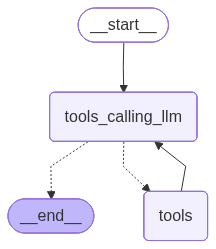

In [ ]:
# ChatBot

from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

# Node definition
def tool_calling_llm(state : State) :
    return {"messages" : [groq_with_tools.invoke(state["messages"])]}

# Build Graph
builder = StateGraph(State)

# Nodes
builder.add_node("tools_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

# Edges
builder.add_edge(START, "tools_calling_llm")
builder.add_conditional_edges(
    "tools_calling_llm", tools_condition
)
builder.add_edge("tools", "tools_calling_llm")
graph = builder.compile()


# view
display(Image(graph.get_graph().draw_mermaid_png()))



# main thing to understand here is to understand, how to connect different nodes with each. According to the connection the Agents will work

I have asked LLM to give AI new and do some calculation
- It will use API tool to generate the news
- And It will provides tools such add, multiply for the calculation
- Agent is working!

In [35]:
message = graph.invoke({"messages" : HumanMessage(content = "Provide me the top 10 AI news of January 2026, add 438 plus 234 and multiply by 0 ")})

for m in message['messages'] :
    m.pretty_print()



================================ Human Message =================================

Provide me the top 10 AI news of January 2026, add 438 plus 234 and multiply by 0 
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (rjtvgahfa)
 Call ID: rjtvgahfa
  Args:
    query: top 10 AI news January 2026
  add (yc28ckmc6)
 Call ID: yc28ckmc6
  Args:
    a: 438
    b: 234
  multiply (g93ehycdw)
 Call ID: g93ehycdw
  Args:
    a: 672
    b: 0
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "AI News That Matters for Builders: January 1-8, 2026 (plus the ...", "url": "https://natesnewsletter.substack.com/p/ai-news-that-matters-for-builders", "content": "Nate\n\nJan 10, 2026\n\n∙ Paid\n\nIf you took time off over the holidays, good for you. AI did not. The first week of 2026 has delivered one of the most consequential news cycles in recent memory: NVIDIA 